In [1]:
import pyoma.browser.db as db

oma_database_address = "/Users/computer/DessimozLab/programming/OmaServer.h5"
oma_db = db.Database(oma_database_address)

Cannot load SequenceSearch. Any future call to seq_search will fail!
Traceback (most recent call last):
  File "/Users/computer/DessimozLab/software/pyoma/pyoma/browser/db.py", line 1896, in __init__
    self.seq_idx = self.seq_idx()
  File "/Users/computer/miniconda3/lib/python3.8/site-packages/tables/link.py", line 393, in __call__
    self.extfile = tables.open_file(filename, **kwargs)
  File "/Users/computer/DessimozLab/software/pyoma/pyoma/browser/db.py", line 106, in synchronized_open_file
    return _tables_file._original_open_file(*args, **kwargs)
  File "/Users/computer/miniconda3/lib/python3.8/site-packages/tables/file.py", line 315, in open_file
    return File(filename, mode, title, root_uep, filters, **kwargs)
  File "/Users/computer/DessimozLab/software/pyoma/pyoma/browser/db.py", line 96, in __init__
    super(ThreadsafeFile, self).__init__(*args, **kargs)
  File "/Users/computer/miniconda3/lib/python3.8/site-packages/tables/file.py", line 778, in __init__
    self._g_ne

In [2]:
import statistics as stats

# Create a dictionary {GO term ID: information content}

In [3]:
import pandas as pd

def inf_cont(address):
    
    #Create a data frame from the text file, remove the third column
    df = pd.read_csv(address, sep = '\t')
    del df['freq']

    #Convert the dataframe to an array
    df = df.to_numpy()

    #Create a dictionary where {GO term ID: informaiton content}
    inf_content = {}
    for i in df:
        inf_content[i[0]] = i[1]
    
    return inf_content

inf_content = inf_cont('./go_inf_content/go_positive_annotations.tsv')

# Functions 

## Method for finding pairwise orthologs between two species

In [15]:
import numpy as np

def pairwise_orthologs(species, model_organism):
    
    '''Method that finds pairwise orthologs between two species
    Output: NumPy array, 0th column is the gene of the species of interest and
    1st column is the gene of a potential model organism'''
    
    COLUMN_COUNTER = 2
    ROW_COUNTER = 0
    
    zeroth_column_list = []
    first_column_list = []
    
    model_genome = [i[0] for i in oma_db.all_proteins_of_genome(model_organism)]
    species_genome = [i[0] for i in oma_db.all_proteins_of_genome(species)]
    
    for gene in species_genome:
        genes_orthologs = [pair[1] for pair in oma_db.get_vpairs(gene)]
        
        for ortholog in genes_orthologs:
            if ortholog in model_genome:
                ROW_COUNTER += 1
                zeroth_column_list.append(gene)
                first_column_list.append(ortholog)
                
    output = np.empty((ROW_COUNTER, COLUMN_COUNTER), dtype = int)
    
    output[:,0] = zeroth_column_list
    output[:,1] = first_column_list
    
    return(output)

In [16]:
def HOG_induced_orthologs(species, model_organism):
    
    '''Method that finds HOG induced pairwise orthologs between two species
    Output: NumPy array, 0th column is the gene of the species of interest and
    1st column is the gene of a potential model organism'''
    
    COLUMN_COUNTER = 2
    ROW_COUNTER = 0
    
    zeroth_column_list = []
    first_column_list = []
    
    model_genome = [i[0] for i in oma_db.all_proteins_of_genome(model_organism)]
    species_genome = [i[0] for i in oma_db.all_proteins_of_genome(species)]
    
    for gene in species_genome:
        genes_orthologs = [pair[1] for pair in oma_db.get_hog_induced_pairwise_orthologs(gene)]
        
        for ortholog in genes_orthologs:
            if ortholog in model_genome:
                ROW_COUNTER += 1
                zeroth_column_list.append(gene)
                first_column_list.append(ortholog)
                
    output = np.empty((ROW_COUNTER, COLUMN_COUNTER), dtype = int)
    
    output[:,0] = zeroth_column_list
    output[:,1] = first_column_list
    
    return(output)

## Function that determines GO overlap between each pair of orthologs

In [17]:
def GO_overlap(array):
    
    '''This function determines common GO terms.
    Input: array, a numpy array of pairwise orthologs
    Output is a list of lists:
    [[pair, [bio process GO overlap], perc_similarity],...]'''
    
    output = []
    
    for pair in array:
        
        annos_gene1 = oma_db.get_gene_ontology_annotations(pair[0])
        annos_gene2 = oma_db.get_gene_ontology_annotations(pair[1])
        
        term1 = set(oma_db.gene_ontology.term_by_id(annos_gene1[i]['TermNr']) for i in range(len(annos_gene1)))
        term2 = set(oma_db.gene_ontology.term_by_id(annos_gene2[i]['TermNr']) for i in range(len(annos_gene2)))
        
    
        overlap = [int(('{0}'.format(a)).strip('GO:')) for a in term1.intersection(term2)]
        overlap_defined = []
        
        for i in overlap:
            if i in list(inf_content.keys()):
                overlap_defined.append(i)
                
        union = [int(('{0}'.format(a)).strip('GO:')) for a in term1.union(term2)]
        
        union_defined = []
        
        for i in union:
            if i in list(inf_content.keys()):
                union_defined.append(i)
        
        bio_process_overlap = []
        for t in overlap:
            if oma_db.gene_ontology.term_by_id(t).aspect == 1:
                bio_process_overlap.append(t)
        
        #The output should only contain pairs that share biological process GO terms
        
        if len(bio_process_overlap) != 0:
            small_list = [pair]
            small_list.append(bio_process_overlap)
                        
            intrsctn_inf_cont = sum(list(inf_content[i] for i in overlap_defined))
            union_inf_cont = sum(list(inf_content[e] for e in union_defined))

            try:
                similarity = 100*intrsctn_inf_cont/union_inf_cont
                small_list.append(similarity)
                output.append(small_list) 
            except ZeroDivisionError:
                pass
        
    return output

In [18]:
def GO_overlap1(array):
    
    '''This function determines common GO terms.
    Input: array, a numpy array of pairwise orthologs
    Output is a list of lists:
    [[pair, [bio process GO overlap], perc_similarity],...]'''
    
    output = []
    
    for pair in array:
        
        annos_gene1 = oma_db.get_gene_ontology_annotations(pair[0])
        annos_gene2 = oma_db.get_gene_ontology_annotations(pair[1])
        
        term1 = set(oma_db.gene_ontology.term_by_id(annos_gene1[i]['TermNr']) for i in range(len(annos_gene1)))
        term2 = set(oma_db.gene_ontology.term_by_id(annos_gene2[i]['TermNr']) for i in range(len(annos_gene2)))
        
        term1_plus_parents = set()
        for i in term1:
            term1_plus_parents.update(go.get_superterms_incl_queryterm(i))
        term1_plus_parents_ids = set(t.id for t in term1_plus_parents)
        
        term2_plus_parents = set()
        for i in term2:
            term2_plus_parents.update(go.get_superterms_incl_queryterm(i))
        term2_plus_parents_ids = set(t.id for t in term2_plus_parents)
        
        overlap = [int(('{0}'.format(a)).strip('GO:')) for a in term1_plus_parents_ids.intersection(term2_plus_parents_ids)]
        overlap_defined = []
        
        #Only consider GO terms that are present in the Alex's file ('defined') and with information content >= 5
        for i in overlap:
            if i in list(inf_content.keys()):
                if inf_content[i] >=5:
                    overlap_defined.append(i)
                
        union = [int(('{0}'.format(a)).strip('GO:')) for a in term1_plus_parents_ids.union(term2_plus_parents_ids)]
        union_defined = []
        
        for i in union:
            if i in list(inf_content.keys()):
                if inf_content[i] >=5:
                    union_defined.append(i)
        
        #The output only includes BP overlapping GO terms
        bio_process_overlap = []
        for t in overlap_defined:
            if oma_db.gene_ontology.term_by_id(t).aspect == 1:
                bio_process_overlap.append(t)
        
        if len(bio_process_overlap) != 0:
            small_list = [pair]
            small_list.append(bio_process_overlap)
            
            intrsctn_inf_cont = sum(list(inf_content[i] for i in overlap_defined))
            union_inf_cont = sum(list(inf_content[e] for e in union_defined))
                
            try:
                similarity = 100*intrsctn_inf_cont/union_inf_cont
                small_list.append(similarity)
                output.append(small_list) 
            except ZeroDivisionError:
                pass
        
    return output

## Finding orthologs with the highest functional similarity

In [19]:
def high_similarity_fnctn_ogs(GO_overlap_output, threshold):
    
    '''This function finds orthologous pairs where similarity > threshold
    Input: GO_overlap array & lower thresshold
    Output: list of lists [[pair, [bio process GO overlap], perc_similarity],...] '''
    
    output = []
    
    for i in GO_overlap_output:
         if i[2] >= threshold:
                output.append(i)
    
    return output

## Finding GO terms based on how many times they occur in the overlap

In [20]:
def frequency_GO_filter(high_sim_fn_output, lower_limit, upper_limit):
    
    '''Gives a list of overlapping GO terms that occur between lower_ and upper_limit times + count
    Input: high functional similarity array & lower threshold count value
    Output: [(GO_ID1, count1), (GO_ID2, count2),...]'''
    
    large_list = []
    output = []
    
    for i in high_sim_fn_output:
        large_list += i[1]
        
    large_set = set(large_list)
    
    for i in large_set:
        count = large_list.count(i)
        if count >= lower_limit and count <= upper_limit:
            output.append((i, count))
            
    return output

## Mapping OMA ID to Gene Name from UniProt

In [6]:
xref_mapper = oma_db.id_mapper['XRef']

def gene_name_mapper(entry_nr):
    
    '''Map OMA ID to UniProt Gene Name'''

    x = xref_mapper.map_entry_nr(entry_nr)
    
    for i in x:
        if i['source'] == 'UniProtKB/TrEMBL':
            return(i['xref'])
    for i in x:
        if i['source'] == 'UniProtKB/SwissProt':
            return(i['xref'])
    for i in x:
        if i['source'] == 'Gene Name':
            return(i['xref'])
    return(str(entry_nr))

/Users/computer/miniconda3/lib/python3.8/site-packages/tables/leaf.py:402: PerformanceWarning: The Leaf ``/_i_XRef/XRefId/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


## Create list of lists [GO ID, [human genes], [model_genes], no. of orth, similarity]

In [22]:
def table2(species, frequency_GO_filter_output,high_similarity_fnctn_ogs_output, threshold):
    
    '''Creates pandas dataframe [GO ID, [human genes], [model genes], no. of orthologs, av. similarity]'''
    
    output = [] 
    
    for i in frequency_GO_filter_output:
        small_list = []
        human_genes = []
        sp_genes = []
        try:
            if inf_content[i[0]] >= threshold:
                small_list.append(i[0])
                small_list.append(species)
                s = []
                for e in high_similarity_fnctn_ogs_output:
                    if i[0] in e[1]:
                        human_genes.append(e[0][0])
                        sp_genes.append(e[0][1])
                        s.append(e[2])
                av_sim = sum(s)/len(human_genes)
                if len(s) > 1:
                    st_dev = round(stats.stdev(s),2)
                else:
                    st_dev = '0.00'
                av_and_st_dev = str(round(av_sim,2)) + ' +/- ' + str(st_dev)
                h_genes_uniprot = []
                for t in human_genes:
                    h_genes_uniprot.append(gene_name_mapper(t))
                #if len(human_genes) > 1:
                small_list.append(','.join(h_genes_uniprot))
                #else:
                    #small_list.append(h_genes_uniprot[0])
                sp_genes_uniprot = []
                for t in sp_genes:
                    sp_genes_uniprot.append(gene_name_mapper(t))
                #if len(sp_genes) > 1: 
                small_list.append(','.join(sp_genes_uniprot))
                #else:
                    #small_list.append(sp_genes_uniprot[0])
                small_list.append(len(human_genes))
                small_list.append(av_and_st_dev)
                output.append(small_list)
        except KeyError:
            pass
    
    df = pd.DataFrame(output, columns = ['GO ID', 'Species', 'H Genes', 'S Genes', 'No. of ogs','Average % func. similarity'])
                
    return df

In [23]:
def table1(species, frequency_GO_filter_output,high_similarity_fnctn_ogs_output, threshold):
    
    '''Create table ['GO ID', 'Species', 'HUMAN Gene', 'Species Gene', 'Functional Similarity']'''
    output = []
    
    for i in high_similarity_fnctn_ogs_output:
        small_list = []
        for e in frequency_GO_filter_output:
            try:
                if inf_content[e[0]] >= 5:
                    if e[0] in i[1]:
                        small_list.append(e[0])
                        small_list.append(species)
                        small_list.append(gene_name_mapper(i[0][0]))
                        small_list.append(gene_name_mapper(i[0][1]))
                        small_list.append(round(i[2],2))
                        output.append(small_list)
                        break
            except KeyError:
                pass
        
    
    df = pd.DataFrame(output, columns = ['GO ID', 'Species', 'H Gene', 'S Gene', '% Func. Similarity' ])
                    
    return df
    

In [24]:
def save_histogram(overlap, file_name):
    
    '''Save functional similarity histogram as a png file'''
    
    sim_list3 = [i[2] for i in overlap]
    num_bins3 = np.arange(0, 100.5, 0.5).tolist()
    n, bins, patches = plt.hist(sim_list3, num_bins3,facecolor='purple' )
    plt.title('New Similarity Calculations')
    plt.xlabel('Functional Similarity (%)')
    plt.ylabel('No. of orthologous pairs')
    plt.savefig(filename)
    

# Candidate 1: Dyctiostelium discoideum

In [19]:
og_pairs1 = pairwise_orthologs('HUMAN', 'DICDI')
print('There are {} pairwise orthologs in Dyctiostelium discoideum.\n'.format(len(og_pairs1)))

There are 4857 pairwise orthologs in Dyctiostelium discoideum.



In [21]:
import pickle

file = 'DICDI_orthologs.pkl'
open_file = open(file, 'wb')
pickle.dump(og_pairs1, open_file)
open_file.close()

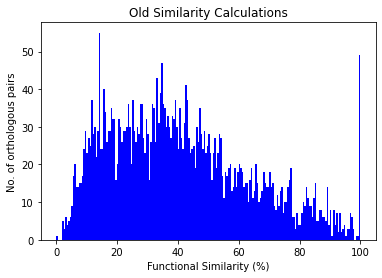

In [16]:
#Histogram for percentage similarity

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

sim_list1 = [i[2] for i in overlap1]
num_bins1 = np.arange(0, 100.5, 0.5).tolist()

n, bins, patches = plt.hist(sim_list1, num_bins1, facecolor='blue')
plt.title('Old Similarity Calculations')
plt.xlabel('Functional Similarity (%)')
plt.ylabel('No. of orthologous pairs')
plt.show()

In [27]:
overlap1_new = GO_overlap1(og_pairs1)

In [26]:
go = oma_db.gene_ontology

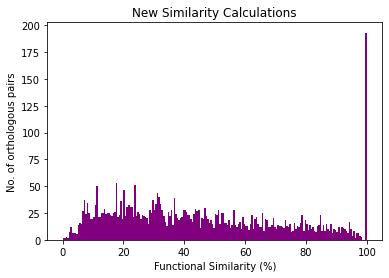

In [37]:
#Histogram for percentage similarity taking into account parent GO

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

sim_list3 = [i[2] for i in overlap1_new]
num_bins3 = np.arange(0, 100.5, 0.5).tolist()
n, bins, patches = plt.hist(sim_list3, num_bins3,facecolor='purple' )
plt.title('New Similarity Calculations')
plt.xlabel('Functional Similarity (%)')
plt.ylabel('No. of orthologous pairs')
plt.show()

In [28]:
similar_ogs_new = high_similarity_fnctn_ogs(overlap1_new, 5)
print(len(similar_ogs_new))

3793


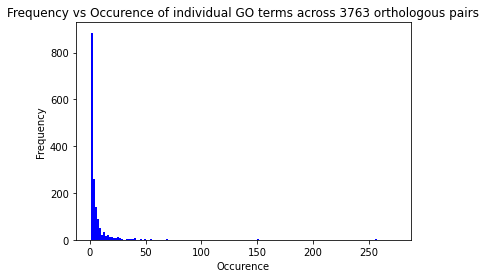

In [40]:
#Histogram for frequeny of GO terms

freq = []
all_go_terms = []

for i in similar_ogs:
    
    all_go_terms += i[1]
    
no_duplicates = set(all_go_terms)

for i in no_duplicates:
        count = all_go_terms.count(i)
        freq.append(count)
    
num_bins1_1 = 150

n, bins, patches = plt.hist(freq, num_bins1_1, facecolor='blue')
plt.title('Frequency vs Occurence of individual GO terms across 3763 orthologous pairs')
plt.xlabel('Occurence')
plt.ylabel('Frequency')
plt.show()

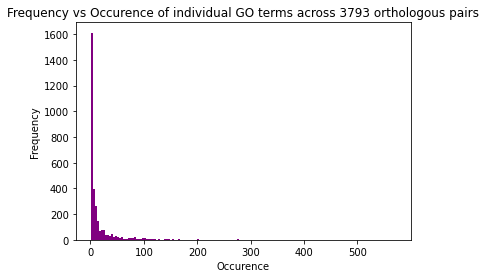

In [41]:
#Histogram for frequeny of GO terms

freq = []
all_go_terms = []

for i in similar_ogs_new:
    
    all_go_terms += i[1]
    
no_duplicates = set(all_go_terms)

for i in no_duplicates:
        count = all_go_terms.count(i)
        freq.append(count)
    
num_bins1_1 = 150

n, bins, patches = plt.hist(freq, num_bins1_1, facecolor='purple')
plt.title('Frequency vs Occurence of individual GO terms across 3793 orthologous pairs')
plt.xlabel('Occurence')
plt.ylabel('Frequency')
plt.show()

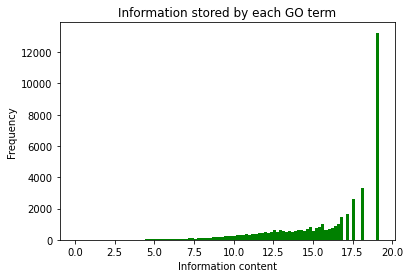

In [99]:
#Histogram for information content values of all GO terms

information = list(inf_content.values())

num_bins1_1 = 100

n, bins, patches = plt.hist(information, num_bins1_1, facecolor='green')
plt.title('Information stored by each GO term')
plt.xlabel('Information content')
plt.ylabel('Frequency')
plt.show()